In [1]:
from config import *

## region selection

In [2]:
file_sigma='nh3_whole_1arcmin_resz_Sigma_flag_20p_new.fits'
file_Tk='nh3_whole_1arcmin_resz_Tkin_flag_tpeak3_20p_new.fits'

In [3]:
sigma = fits.getdata(file_sigma)
tk,hd = fits.getdata(file_Tk,header=True)

In [4]:
def setup_plot( fig, cmap='inferno', vmin=0, vmax=10., col_text='Sample (Jy/beam)', 
               do_yso=False, yso_color='white', star_file=None, beam_color='green'):

    fig.show_colorscale( cmap=cmap, vmin=vmin, vmax=vmax,stretch='linear')
    
    fig.add_colorbar()
    fig.colorbar.show(location='top',axis_label_text=col_text)
    
    fig.add_beam(color=beam_color)
    
    distance = 138.4 *u.pc
    scale=(0.2*u.pc/distance*u.rad).to(u.deg)
    fig.add_scalebar(scale, label='0.2 pc')
    
    fig.ticks.set_color('black')
    
    fig.add_label( 0.1, 0.1, 'L1688', relative=True,color='k',size=15)
    
    if do_yso:
        ra = np.loadtxt(star_file,usecols=0)
        dec = np.loadtxt(star_file,usecols=1)
        fig.show_markers(ra,dec,marker='*',s=20,c=yso_color,linewidth=0.7,zorder=4)

No contour levels were found within the data range.


INFO: Auto-setting resolution to 28.7558 dpi [aplpy.core]


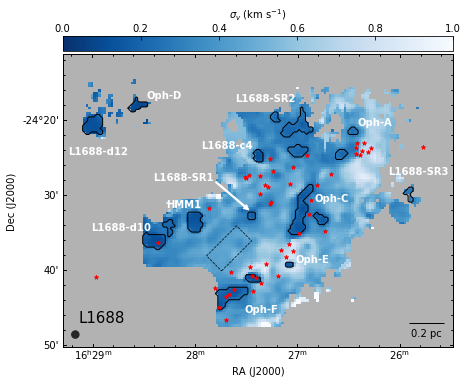

In [74]:
fig = aplfig( file_sigma,figsize=(7,7))

text_color='white'
contour_color='k'

cmap = plt.cm.get_cmap('Blues_r')
cmap.set_bad('0.7')

setup_plot( fig, cmap=cmap, vmin=0, vmax=1, col_text = r'$\sigma_v$ (km s$^{-1}$)',
           do_yso=True, star_file='L1688_protostar_list.txt', yso_color='red', beam_color='0.15')

for r in sort_reg:
    file_mask = r+'_mask.fits'
    fig.show_contour( file_mask, levels=[2.5], colors=contour_color,linewidths=1)

mask_cloud1 = 'mask_mean_cloud_1-0_new2.fits'    
fig.show_contour( mask_cloud1, levels=[1], colors=contour_color,linewidths=0.7, linestyles='dashed')

fig.add_label( 0.09, 0.67, reg_lab['d12'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.26, 0.86, reg_lab['OphD'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.15, 0.41, reg_lab['d10'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.31, 0.49, reg_lab['d9'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.51, 0.13, reg_lab['OphF'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.42, 0.69, reg_lab['c4'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.52, 0.85, reg_lab['top'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.31, 0.58, reg_lab['B_sou'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.64, 0.3, reg_lab['OphE'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.69, 0.51, reg_lab['OphC'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.8, 0.77, reg_lab['OphA'], relative=True,color=text_color,size=10,weight='bold')
fig.add_label( 0.91, 0.6, reg_lab['west'], relative=True,color=text_color,size=10,weight='bold')

fig.show_arrows(246.95, -24.47, -0.08, -0.062, width=0.5, head_width=2, head_length=2, color=text_color)

fig.savefig('L1688_region_selection_letter.pdf')


##     

## Spectra and fit

### Generate average spectra

In [111]:
data11,hd11 = fits.getdata('nh3_11_whole_cube_1arcmin_resz.fits',header=True)
data22,hd22 = fits.getdata('nh3_22_whole_cube_1arcmin_resz.fits',header=True)

hd11['naxis1'] = 1 
hd22['naxis1'] = 1
hd11['naxis2'] = 1
hd22['naxis2'] = 1

sc11_raw = SpectralCube.read('nh3_11_whole_cube_1arcmin_resz.fits')
sc22_raw = SpectralCube.read('nh3_22_whole_cube_1arcmin_resz.fits')

sc11 = sc11_raw.with_spectral_unit( u.km / u.s, velocity_convention = 'radio')
sc22 = sc22_raw.with_spectral_unit( u.km / u.s, velocity_convention = 'radio')
sc11_raw = 0
sc22_raw = 0

chan_w11 = np.mean((sc11.spectral_axis-np.roll(sc11.spectral_axis,1))[1:]).value
chan_w22 = np.mean((sc22.spectral_axis-np.roll(sc22.spectral_axis,1))[1:]).value 
sc11 = 0
sc22 = 0

vel_map = fits.getdata('nh3_whole_1arcmin_resz_Vlsr_flag_20p_new.fits')


def gen_avg_spec(rg=None, align=False, mncld='new2'):
    
    if rg not in sort_reg+['mean_cloud']:
        print('possible regions(rg) are : ', *sort_reg, 'mean_cloud')

    if rg == 'mean_cloud':
        ext = mncld
        mask = fits.getdata('mask_mean_cloud_1-0'+ext+'.fits')==1

    else :
        ext=''
        mask = rg + '_mask.fits'        

    d11 = data11[:,mask]
    d22 = data22[:,mask]
        
    if align :
        suff = '_v_al_0'
        
        vel = vel_map[mask]

        v_avg = np.nanmean(vel)

        sp11 = np.zeros(d11.shape[0])
        sp22 = np.zeros(d22.shape[0])

        for i in range(d11.shape[1]):

            if np.isnan(vel[i]) :
                dv = v_avg
            else :
                dv = vel[i] 

            del_chan11 = dv/chan_w11    
            del_chan22 = dv/chan_w22

            if np.isfinite(d11[0,i]):
                temp_1 = channelShift(d11[:,i],del_chan11)
                d11[ :, i] = temp_1
                temp_2 = channelShift(d22[:,i],del_chan22)
                d22[ :, i] = temp_2

    else:
        suff = ''
        
    sp11 = np.nanmean(d11,axis=1)
    sp22 = np.nanmean(d22,axis=1)

    sp_ar11 = np.reshape(sp11,[sp11.shape[0],1,1])
    sp_ar22 = np.reshape(sp22,[sp22.shape[0],1,1])

    out11 = rg+suff+'_11'+ext+'.fits'
    out22 = rg+suff+'_22'+ext+'.fits'

    fits.writeto(out11,sp_ar11,hd11,overwrite=True)
    fits.writeto(out22,sp_ar22,hd22,overwrite=True)  

In [ ]:
for reg in sort_reg+['mean_cloud']:
    for bl in [True,False]:
        gen_avg_spec(rg=reg,align=bl)

### Fit 

In [75]:
def fit_spec(rg=None,align=False,cmp=1):
    ext = ''
    suff = ''
    vel = 3.75
    if align:
        ext = '_v_al_0'
        vel = 0.0
    if cmp == 2:
        suff = '_2_cmp'

    file11 = rg+ext+'_11.fits'
    file22 = rg+ext+'_22.fits'

    hd11 = fits.getheader(file11)
    hd22 = fits.getheader(file22)    

    sp11_len = fits.getdata(file11).shape[0]
    sp22_len = fits.getdata(file22).shape[0]

    c11 = pyspeckit.Cube(file11)
    c22 = pyspeckit.Cube(file22)

    cb = pyspeckit.CubeStack([c11,c22])

    sp = cb.get_spectrum(0,0)

    #sp.plotter()

    err = [10,10,10,10,10,10]
    guesses = [12,3,14,0.48,vel,0]

    if cmp == 2:
        sp.specfit.Registry.add_fitter('cold_ammonia_2', pyspeckit.spectrum.models.ammonia.cold_ammonia_model(npeaks=2),
                                       6 ) 

        err = [10]*12
        guesses = [11,4,14,0.15,0,0,16,3,14,0.48,0.25,0]

    diff = np.asarray(err)

    T = True
    F = False

    while ~np.all((diff==0)):
        if cmp == 1:
            sp.specfit(fittype='cold_ammonia', guesses=guesses, fixed=[F,F,F,F,F,T], limitedmax=[F,F,F,F,F,T], 
                       maxpars=[50,50,17,2.5,6,1], limitedmin=[T,T,T,T,F,T], minpars=[3,3,12,0.05,1,0])
        if cmp == 2:
            sp.specfit(fittype='cold_ammonia_2', guesses=guesses, fixed=[F,F,F,F,F,T]*2, limitedmax=[F,F,F,F,F,T]*2, 
                       maxpars=[50,50,17,2.5,6,1]*2, limitedmin=[T,T,T,T,F,T]*2, minpars=[3,3,12,0.05,1,0]*2)

        guesses = sp.specfit.modelpars
        er = sp.specfit.modelerrs

        diff = np.asarray(er)-np.asarray(err)

        err = er

    #plt.title(r)

    model = sp.specfit.model

    mod11 = model[:sp11_len]
    mod22 = model[-sp22_len:]

    mod_ar11 = np.reshape(mod11,[mod11.shape[0],1,1])
    mod_ar22 = np.reshape(mod22,[mod22.shape[0],1,1])


    fits.writeto(rg+'_model'+ext+'_11'+suff+'.fits', mod_ar11, hd11, overwrite=True)
    fits.writeto(rg+'_model'+ext+'_22'+suff+'.fits',mod_ar22,hd22,overwrite=True)        
    
    return sp.specfit

In [11]:
def fit_spec_mean_cloud(align=False,cmp=1,new=''):
    ext = ''
    suff = ''
    vel = 3.75
    if align:
        ext = '_v_al_0'
        vel = 0.0
    if cmp == 2:
        suff = '_2_cmp'

    file11 = 'mean_cloud'+ext+'_11'+new+'.fits'
    file22 = 'mean_cloud'+ext+'_22'+new+'.fits'

    hd11 = fits.getheader(file11)
    hd22 = fits.getheader(file22)    

    sp11_len = fits.getdata(file11).shape[0]
    sp22_len = fits.getdata(file22).shape[0]

    c11 = pyspeckit.Cube(file11)
    c22 = pyspeckit.Cube(file22)

    cb = pyspeckit.CubeStack([c11,c22])

    sp = cb.get_spectrum(0,0)

    #sp.plotter()

    err = [10,10,10,10,10,10]
    guesses = [12,3,14,0.48,vel,0]

    if cmp == 2:
        sp.specfit.Registry.add_fitter('cold_ammonia_2', pyspeckit.spectrum.models.ammonia.cold_ammonia_model(npeaks=2),
                                       6 ) 

        err = [10]*12
        guesses = [11,4,14,0.15,0,0,16,3,14,0.48,0.25,0]

    diff = np.asarray(err)

    T = True
    F = False

    while ~np.all((diff==0)):
        if cmp == 1:
            sp.specfit(fittype='cold_ammonia', guesses=guesses, fixed=[F,F,F,F,F,T], limitedmax=[F,F,F,F,F,T], 
                       maxpars=[50,50,17,2.5,6,1], limitedmin=[T,T,T,T,F,T], minpars=[3,3,12,0.05,1,0])
        if cmp == 2:
            sp.specfit(fittype='cold_ammonia_2', guesses=guesses, fixed=[F,F,F,F,F,T]*2, limitedmax=[F,F,F,F,F,T]*2, 
                       maxpars=[50,50,17,2.5,6,1]*2, limitedmin=[T,T,T,T,F,T]*2, minpars=[3,3,12,0.05,1,0]*2)

        guesses = sp.specfit.modelpars
        er = sp.specfit.modelerrs

        diff = np.asarray(er)-np.asarray(err)

        err = er

    #plt.title(r)

    model = sp.specfit.model

    mod11 = model[:sp11_len]
    mod22 = model[-sp22_len:]

    mod_ar11 = np.reshape(mod11,[mod11.shape[0],1,1])
    mod_ar22 = np.reshape(mod22,[mod22.shape[0],1,1])


    fits.writeto('mean_cloud_model'+ext+'_11'+suff+new+'.fits', mod_ar11, hd11, overwrite=True)
    fits.writeto('mean_cloud_model'+ext+'_22'+suff+new+'.fits',mod_ar22,hd22,overwrite=True)        

    dic = {'pars':[],'errs':[]}  

    dic['pars'] = sp.specfit.modelpars
    dic['errs'] = sp.specfit.modelerrs

    dict_fl = open('mean_cloud_par-err'+ext+suff+new+'.pkl', 'wb')  
    pickle.dump(dic, dict_fl)
    dict_fl.close()

In [ ]:
new=ext
fit_spec_mean_cloud(align=i,cmp=j,new=new)

In [115]:
pars01 = {'OphA': [], 'OphC': [], 'OphD': [], 'OphE': [], 'OphF': [], 'd9': [], 'd10': [], 'd12': [], 'c4': [],
          'west': [], 'top': [], 'B_sou': []}
errs01 = {'OphA': [], 'OphC': [], 'OphD': [], 'OphE': [], 'OphF': [], 'd9': [], 'd10': [], 'd12': [], 'c4': [],
          'west': [], 'top': [], 'B_sou': []}

for rg in sort_reg:
    spfit = fit_spec(rg=rg,align=True,cmp=1)
    pars01[rg] = spfit.modelpars
    errs01[rg] = spfit.modelerrs

par_fl = open('par_v_al_0.pkl','rb')
err_fl = open('err_v_al_0.pkl','rb')
pars01 = pickle.load(par_fl)
errs01 = pickle.load(err_fl)
par_fl.close()
err_fl.close()    

#    

## Plot spectra

In [20]:
from spectral_cube import SpectralCube

def load_func(reg_i = 'OphA', ext='_v_al_0', cmp='_2_cmp', new=''):
    """
    """
    cube_11_al = SpectralCube.read( reg_i+ext+'_11'+new+'.fits')
    cube_11_mod = SpectralCube.read( reg_i+'_model'+ext+'_11'+cmp+new+'.fits')
    cube_22_al = SpectralCube.read( reg_i+ext+'_22'+new+'.fits')
    cube_22_mod = SpectralCube.read( reg_i+'_model'+ext+'_22'+cmp+new+'.fits')
    
    cube_11_al_v = cube_11_al.with_spectral_unit( u.km / u.s, velocity_convention = 'radio')
    cube_11_mod_v = cube_11_mod.with_spectral_unit( u.km / u.s, velocity_convention = 'radio')
    cube_22_al_v = cube_22_al.with_spectral_unit( u.km / u.s, velocity_convention = 'radio')
    cube_22_mod_v = cube_22_mod.with_spectral_unit( u.km / u.s, velocity_convention = 'radio')
    return cube_11_al_v, cube_22_al_v, cube_11_mod_v, cube_22_mod_v  

In [13]:
def separate_comp(par,err):
    if par[3]<par[9]:
        par_n = par[:6]
        par_b = par[6:]
        err_n = err[:6]
        err_b = err[6:]
    else :
        par_b = par[:6]
        par_n = par[6:]
        err_b = err[:6]
        err_n = err[6:]
    return par_n, par_b, err_n, err_b 

In [27]:
import pyspeckit

def get_xarr(reg='OphA', ext='_v_al_0', new='new'):
    cube11 = pyspeckit.Cube(reg+ext+'_11'+new+'.fits')
    cube11.unit="K"
    cube11.xarr.refX = pyspeckit.spectrum.models.ammonia.freq_dict['oneone']
    cube11.xarr.refX_unit='Hz'
    cube11.xarr.velocity_convention='radio'
    cube11.xarr.convert_to_unit(u.km/u.s)
    #
    cube22 = pyspeckit.Cube(reg+ext+'_22'+new+'.fits')
    cube22.unit="K"
    cube22.xarr.refX = pyspeckit.spectrum.models.ammonia.freq_dict['twotwo']
    cube22.xarr.refX_unit='Hz'
    cube22.xarr.velocity_convention='radio'
    cube22.xarr.convert_to_unit(u.km/u.s)
    #
    # Get the spectra
    #
    sp11 = cube11.get_spectrum(0,0)
    sp22 = cube22.get_spectrum(0,0)
    #
    xarr11 = sp11.xarr
    xarr22 = sp22.xarr
    
    return xarr11, xarr22

In [43]:
def plot_reg_avg( reg_i = 'OphA', reg_label = 'Oph-A', ext='', c1='k', c2='r', resid=True, new='',
                 load_func=load_func, w1=1,w2=1, fgsz=(8,3), x11=22, x22=22, x1=None,x2=None):
    """
    """
    
    if x1:
        x1_11 = x1
        x1_22 = x1
    if x2:
        x2_11 = x2
        x2_22 = x2
    
    fig, ax = plt.subplots(ncols=2, nrows=1, sharex='col', gridspec_kw={'hspace': 0.02, 'wspace' : 0.25, 
                                                                       'width_ratios':[w1,w2]}, figsize=fgsz)
    # Central core
    cube_11_c,  cube_22_c, cube_11_c_m,cube_22_c_m = load_func(reg_i = reg_i, ext=ext,cmp='',new=new)
    # Plot NH3 (1,1)
    # Core    
    ax[0].plot( cube_11_c.spectral_axis, cube_11_c[:,0,0], drawstyle='steps-mid', lw=0.5, color=c1)
    ax[0].plot( cube_11_c_m.spectral_axis, cube_11_c_m[:,0,0], drawstyle='steps-mid', lw=0.5, color=c2)

    #
    
#     ax[0, 0].text( 0.1, 0.8, 'Core', horizontalalignment='left', transform=ax[0, 0].transAxes)
    #
    #
    ax[0].text( 0.9, 0.9, 'NH$_3$ (1,1)', horizontalalignment='right', transform=ax[0].transAxes)
    ax[0].text( 0.9, 0.8, reg_label, horizontalalignment='right', transform=ax[0].transAxes)

    if ext == '':    
        ax[0].set_xlim(3.5-x11,3.5+x11)
    elif ext == '_v_al_0':
        ax[0].set_xlim(-x11,x11)
    plt.setp( ax, ylabel = 'T$_{MB}$ (K)' )
    ax[0].set(xlabel=' Velocity (km s$^{-1}$)')

    
    
    # Plot NH3 (2,2)
    # Core
    ax[1].plot( cube_22_c.spectral_axis, cube_22_c[:,0,0], drawstyle='steps-mid', lw=0.5, color=c1)
    ax[1].plot( cube_22_c_m.spectral_axis, cube_22_c_m[:,0,0], drawstyle='steps-mid', lw=0.5, color=c2)
    #
    
#     ax[0, 1].text( 0.1, 0.9, 'Core', horizontalalignment='left', transform=ax[0, 1].transAxes)
    #
    #
    #
    if resid:
        ax[0].plot( cube_11_c_m.spectral_axis, -(np.max(cube_11_c[:,0,0]-cube_11_c_m[:,0,0])*1.5)-
                      (cube_11_c_m[:,0,0]-cube_11_c[:,0,0]), drawstyle='steps-mid', lw=0.2, color='grey')
        ax[1].plot( cube_22_c_m.spectral_axis, -(np.max(cube_22_c_m[:,0,0]-cube_22_c[:,0,0]))-
                      (cube_22_c_m[:,0,0]-cube_22_c[:,0,0]), drawstyle='steps-mid', lw=0.2, color='grey')
    ax[1].text( 0.9, 0.9, 'NH$_3$ (2,2)', horizontalalignment='right', transform=ax[1].transAxes)
    ax[1].text( 0.9, 0.8, reg_label, horizontalalignment='right', transform=ax[1].transAxes)

    if ext == '':    
        ax[1].set_xlim(3.5-x22,3.5+x22)
    elif ext == '_v_al_0':
        ax[1].set_xlim(-x22,x22)
    ax[1].set(xlabel=' Velocity (km s$^{-1}$)')
    
#     plt.tight_layout(pad=0.3)
    return fig,ax

In [58]:
def plot_reg_avg_2cmp( reg_i = 'OphA', reg_label = 'Oph-A', load_func = load_func, c1='r', c2='b', pars=None, errs=None, 
                      w1=1, w2=1, fgsz=(8,3), do_res=False, do_sum=False, x11=22, x22=3, new=''):
    """
    """
    fig, ax = plt.subplots(ncols=2, nrows=1, sharex='col', gridspec_kw={'hspace': 0.02, 'wspace' : 0.25, 
                                                                       'width_ratios':[w1,w2]}, figsize=fgsz)
    #
# Load cubes
    #
  # Core
    cube_11_c_al, cube_22_c_al, cube_11_c_m, cube_22_c_m = load_func( reg_i = reg_i, new=new)
    #
# Get the models
    #
    par_c_n, par_c_b = separate_comp(pars,errs)[:2]
    #
    #
# Get xarr to plot models
    #
    xarr11_c, xarr22_c = get_xarr(reg=reg_i, new=new)
    #
    #
    modelf = pyspeckit.spectrum.models.ammonia.cold_ammonia_model().n_modelfunc
    #
    #
# single components from model
    #
    sp11_c_1 = modelf(par_c_n)(xarr11_c)
    sp11_c_2 = modelf(par_c_b)(xarr11_c)
    sp22_c_1 = modelf(par_c_n)(xarr22_c)
    sp22_c_2 = modelf(par_c_b)(xarr22_c)
    #
    #
# Plot NH3 (1,1)
    # 
  # Core
    #
    ax[0].plot( cube_11_c_al.spectral_axis, cube_11_c_al[:,0,0], drawstyle='steps-mid', lw=0.5, color='k')
    #
    ax[0].plot( xarr11_c.value, sp11_c_1, drawstyle='steps-mid', lw=0.5, color=c1)
    ax[0].plot( xarr11_c.value, sp11_c_2, drawstyle='steps-mid', lw=0.5, color=c2)
    #
    #    
#     ax[0].text( 0.1, 0.9, 'Core', horizontalalignment='left', transform=ax[0].transAxes)
    #
    #
    #
    #
# Plot NH3 (2,2)
    # 
  # Core
    #
    ax[1].plot( cube_22_c_al.spectral_axis, cube_22_c_al[:,0,0], drawstyle='steps-mid', lw=0.5, color='k')
    #
    ax[1].plot( xarr22_c.value, sp22_c_1, drawstyle='steps-mid', lw=0.5, color=c1)
    ax[1].plot( xarr22_c.value, sp22_c_2, drawstyle='steps-mid', lw=0.5, color=c2)
    #
    #
#     ax[1].text( 0.1, 0.9, 'Core', horizontalalignment='left', transform=ax[1].transAxes)
    #
    #
# Residual
    #
    if do_res:
        ax[0].plot( cube_11_c_al.spectral_axis, -(np.max(cube_11_c_m[:,0,0]-cube_11_c_al[:,0,0])*2)-
                      (cube_11_c_m[:,0,0]-cube_11_c_al[:,0,0]), drawstyle='steps-mid', lw=0.5, color='grey')
        ax[1].plot( cube_22_c_al.spectral_axis, -(np.max(cube_22_c_m[:,0,0]-cube_22_c_al[:,0,0]))-
                      (cube_22_c_m[:,0,0]-cube_22_c_al[:,0,0]), drawstyle='steps-mid', lw=0.5, color='grey')
    #
# Composite model fit
    #
    if do_sum:
        ax[0].plot(cube_11_c_m.spectral_axis, cube_11_c_m[:,0,0], drawstyle='steps-mid', lw=0.5, color='green')
        ax[1].plot(cube_22_c_m.spectral_axis, cube_22_c_m[:,0,0], drawstyle='steps-mid', lw=0.5, color='green')
    #
# Labels
    #
    ax[0].text( 0.9, 0.9, 'NH$_3$ (1,1)', horizontalalignment='right', transform=ax[0].transAxes)
    ax[0].text( 0.9, 0.8, reg_label, horizontalalignment='right', transform=ax[0].transAxes)
    #
    ax[1].text( 0.9, 0.9, 'NH$_3$ (2,2)', horizontalalignment='right', transform=ax[1].transAxes)
    ax[1].text( 0.9, 0.8, reg_label, horizontalalignment='right', transform=ax[1].transAxes)
    #
    plt.setp( ax, ylabel = 'T$_{MB}$ (K)' )
    #
    ax[0].set(xlabel=' Velocity (km s$^{-1}$)')
    ax[0].set_xlim(-x11,x11)
    #
    ax[1].set_xlim(-x22,x22)
    ax[1].set(xlabel=' Velocity (km s$^{-1}$)')
    
#     plt.tight_layout(pad=0.3)
    return fig,ax

In [82]:
import pickle

dict_fl = open('mean_cloud_par-err_v_al_0_2_cmp_new2.pkl','rb')
dic = pickle.load(dict_fl)
pars_c = dic['pars']
errs_c = dic['errs']
dict_fl.close()
dic=0

par_fl = open('par_v_al_0_2_cmp.pkl','rb')
err_fl = open('err_v_al_0_2_cmp.pkl','rb')
pars = pickle.load(par_fl)
errs = pickle.load(err_fl)
par_fl.close()
err_fl.close()

par_fl = open('par_v_al_0.pkl','rb')
err_fl = open('err_v_al_0.pkl','rb')
pars1 = pickle.load(par_fl)
errs1 = pickle.load(err_fl)
par_fl.close()
err_fl.close()


Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


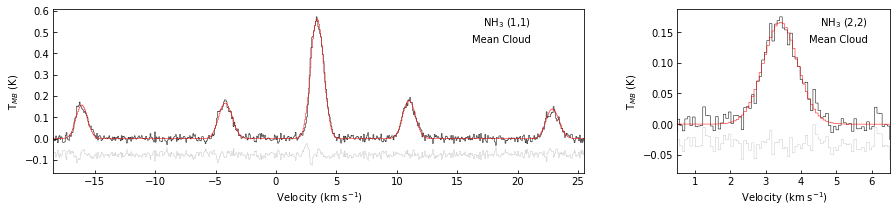

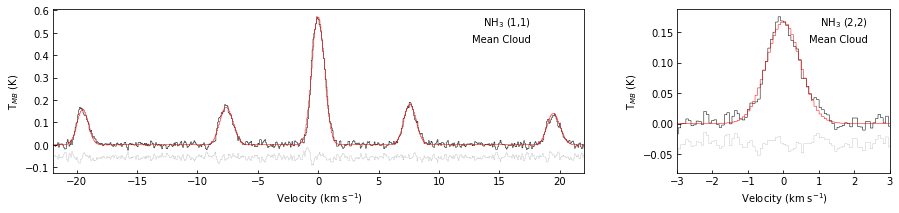

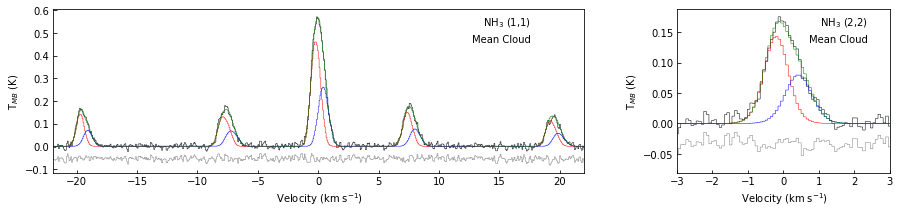

In [29]:
new = '_new2'
par = pars_c
err = errs_c

fig,ax = plot_reg_avg(reg_i='mean_cloud', reg_label='Mean Cloud', ext='', c1='k', c2='r',resid=True,w1=5,w2=2,
                          fgsz=(15,3),x11=22,x22=3,new=new)
fig,ax = plot_reg_avg(reg_i='mean_cloud', reg_label='Mean Cloud', ext='_v_al_0', c1='k', c2='r',resid=True,w1=5,w2=2,
                          fgsz=(15,3),x11=22,x22=3,new=new)
fig,ax = plot_reg_avg_2cmp(reg_i='mean_cloud', reg_label='Mean Cloud', c1='r', c2='b', pars=par, errs=err, 
                           do_res=True, do_sum=True, w1=5, w2=2, fgsz=(15,3),x11=22,x22=3,new=new)


Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.


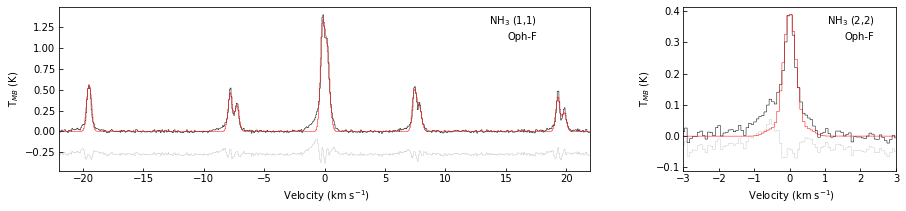

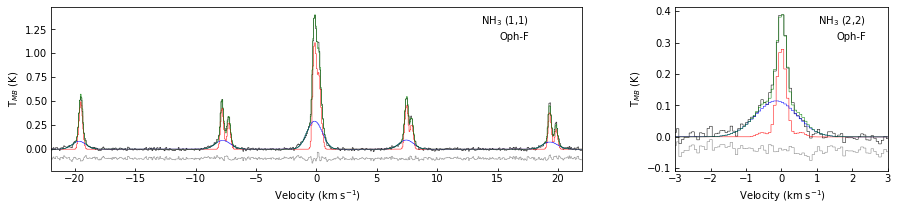

In [56]:
rg = 'OphF'
rg_lb = reg_lab[rg]

par = pars[rg]
err = errs[rg]

# fig,ax = plot_reg_avg(reg_i=rg, reg_label=rg_lb, ext='', c1='k', c2='r',resid=True,w1=5,w2=2,
#                           fgsz=(15,3),x11=22,x22=3,new='')
fig,ax = plot_reg_avg(reg_i=rg, reg_label=rg_lb, ext='_v_al_0', c1='k', c2='r',resid=True,w1=5,w2=2,
                          fgsz=(15,3),x11=22,x22=3,new='')
fig,ax = plot_reg_avg_2cmp(reg_i=rg, reg_label=rg_lb, c1='r', c2='b', pars=par, errs=err, 
                           do_res=True, do_sum=True, w1=5, w2=2, fgsz=(15,3),x11=22,x22=3,new='')


Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_structures.OneDSpectrum'>'s ``array``  or ``quantity`` attribute.
Slice (slice(None, None, None), None) cannot be used on this 1-dimensional array's WCS.  If this is intentional, you  should use this <class 'spectral_cube.lower_dimensional_struct

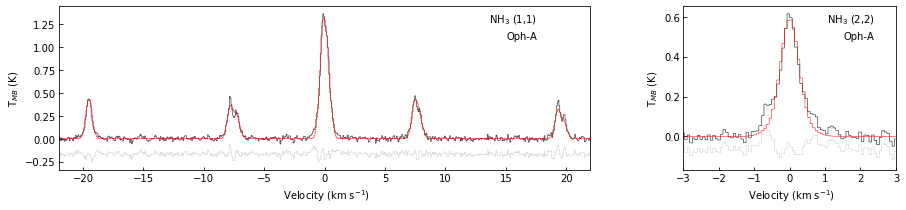

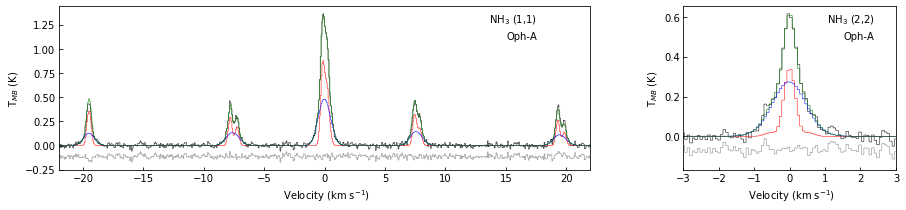

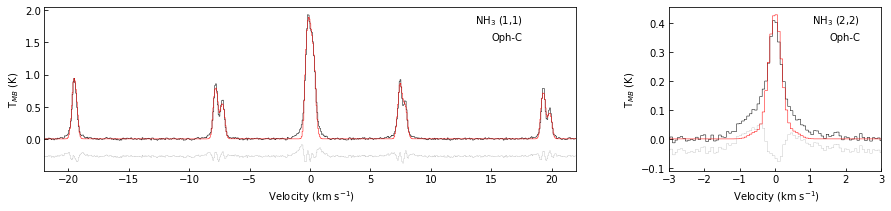

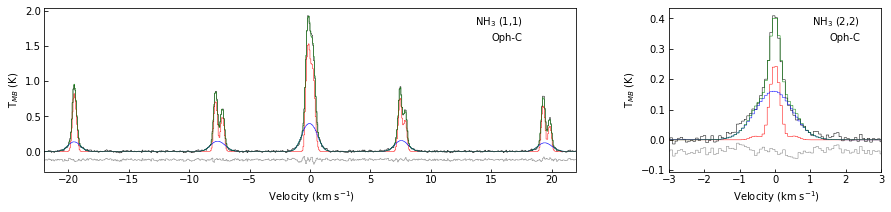

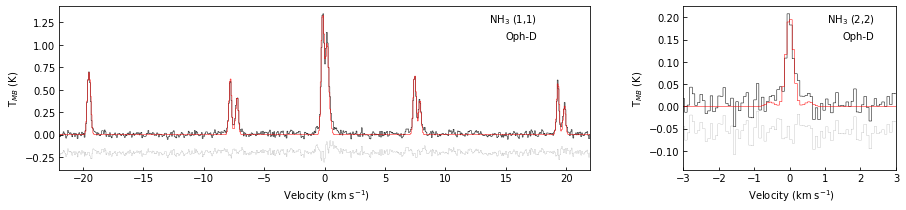

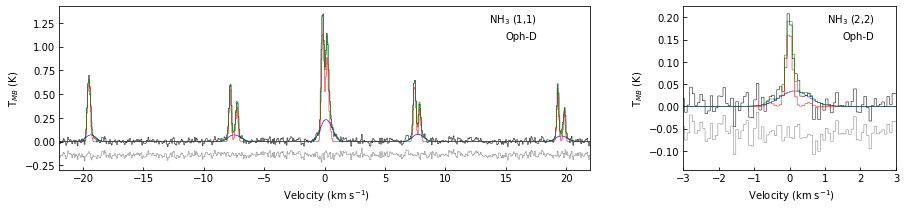

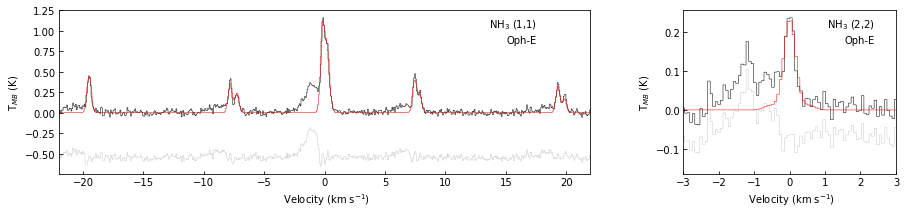

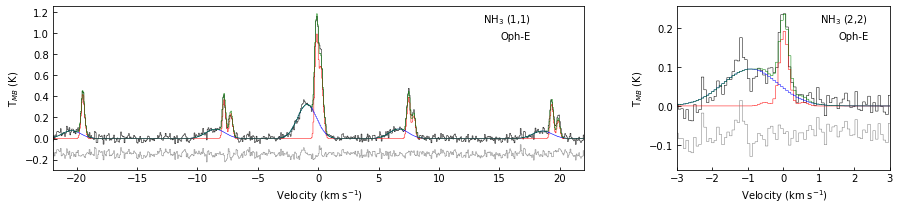

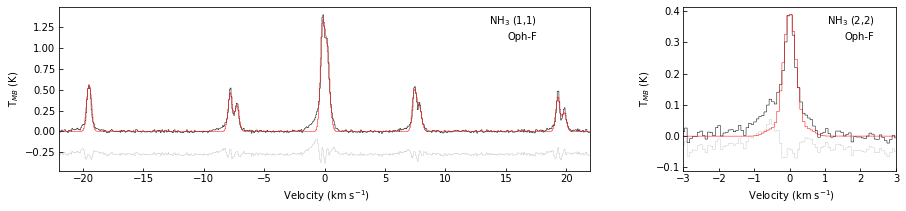

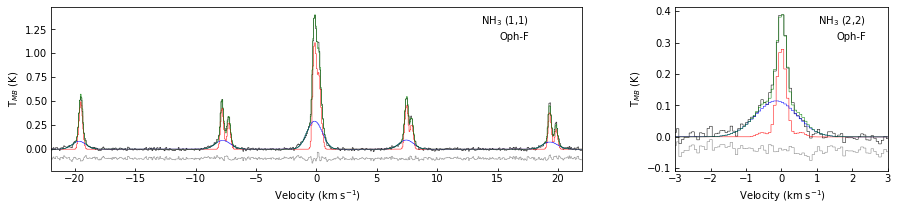

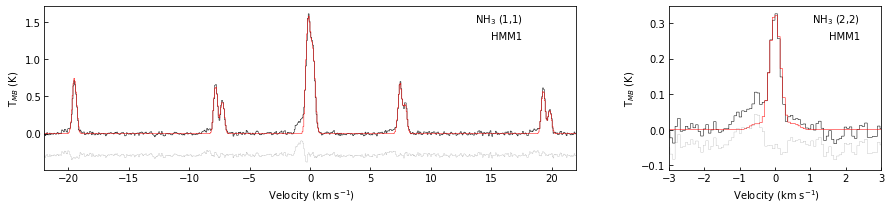

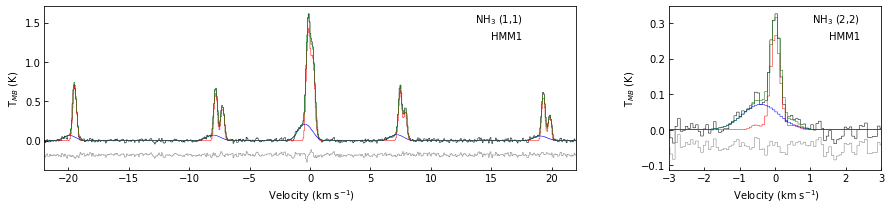

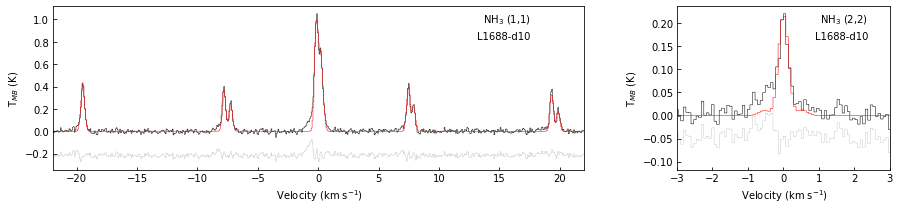

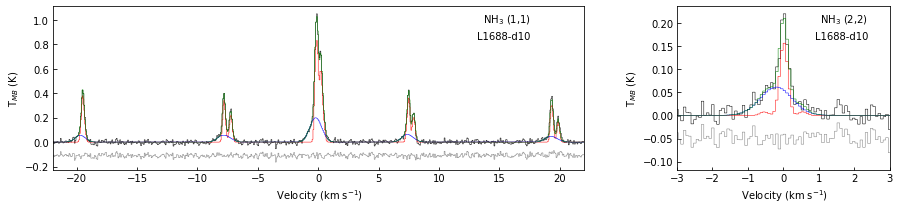

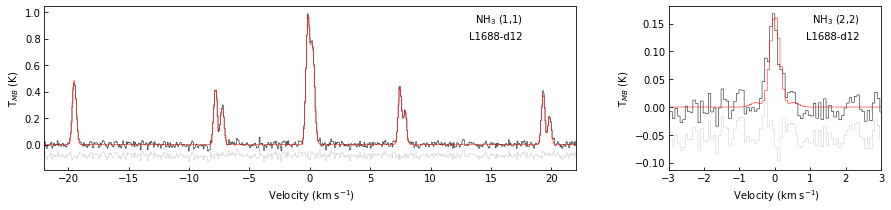

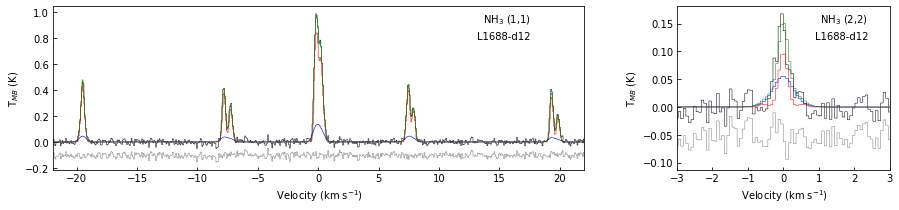

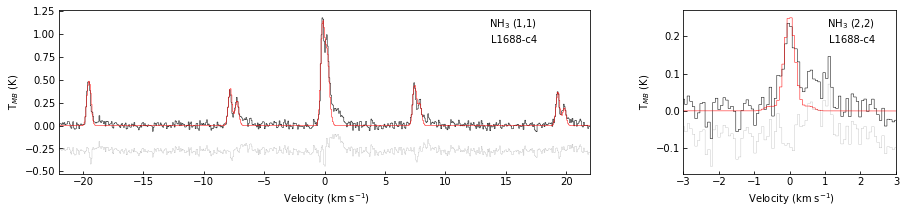

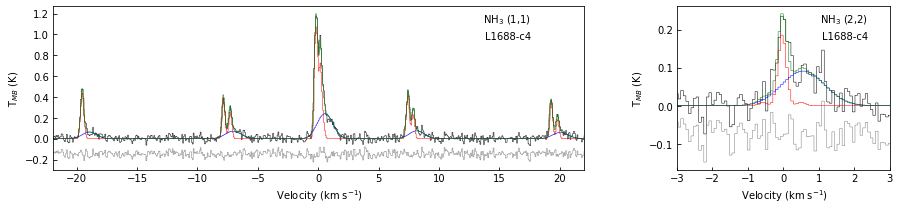

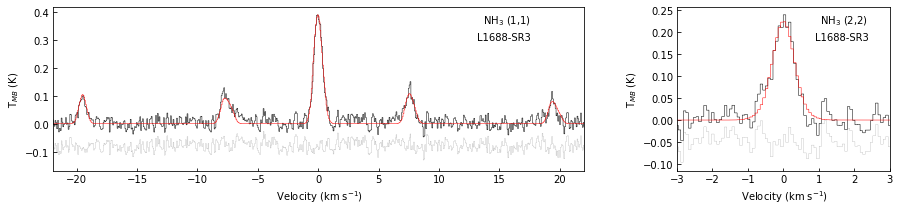

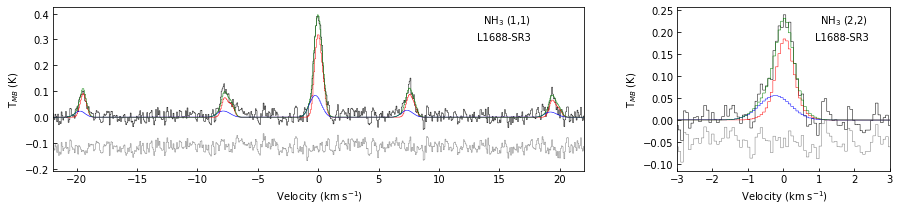

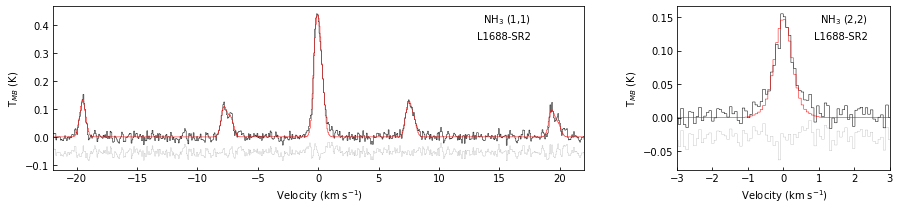

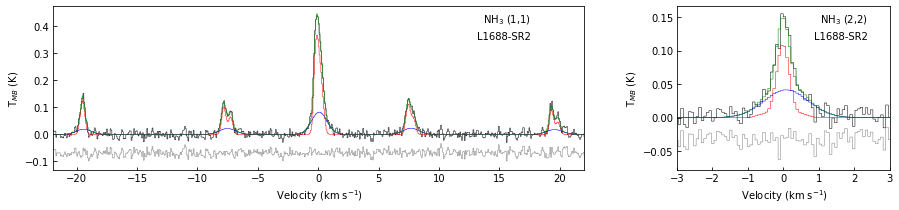

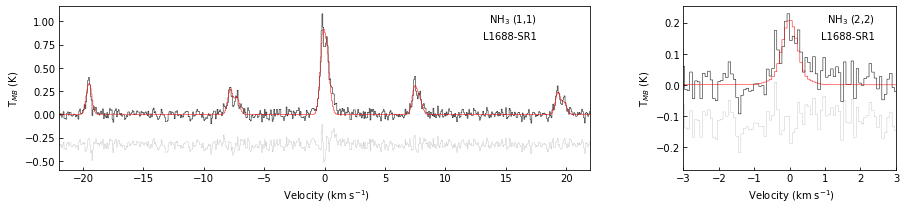

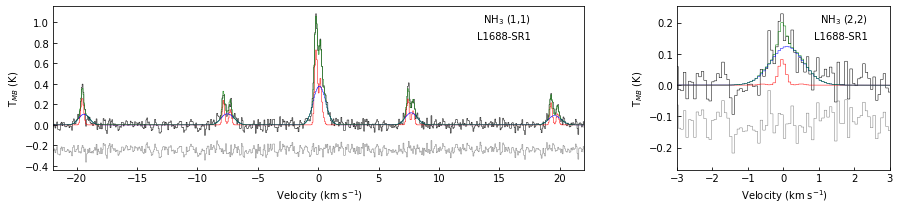

In [116]:
for rg in sort_reg:
    rg_lb = reg_lab[rg]

    par = pars[rg]
    err = errs[rg]

    fig1,ax = plot_reg_avg(reg_i=rg, reg_label=rg_lb, ext='_v_al_0', c1='k', c2='r', resid=True, w1=5, w2=2,
                          fgsz=(15,3), x11=22, x22=3)
    fig2,ax = plot_reg_avg_2cmp(reg_i=rg, reg_label=rg_lb, c1='r', c2='b', pars=par, errs=err, 
                               do_res=True, do_sum=True, w1=5, w2=2, fgsz=(15,3),x11=22,x22=3)
    
    fig1.tight_layout()
    fig2.tight_layout()
    
    fig1.savefig('avg_spec_w_fit_1_cmp_'+rg+'.pdf')
    fig2.savefig('avg_spec_w_fit_2_cmp_'+rg+'.pdf')    

##    

## Comparison between narrow and single component

In [79]:
from scipy import constants as c

In [80]:
def mach(tk, sig, return_sig_nt=False):
    kB = c.k
    mH = c.m_p
    
    sig *= 1000
    
    f = (kB * tk)/mH

    sig_t = np.sqrt(f/17)

    diff = sig**2 - sig_t**2
    sig_nt = np.sqrt(diff)
    
    if return_sig_nt:
        return sig_nt/1000
    
    cs = np.sqrt(f/2.33)
    M = sig_nt/cs

    return M

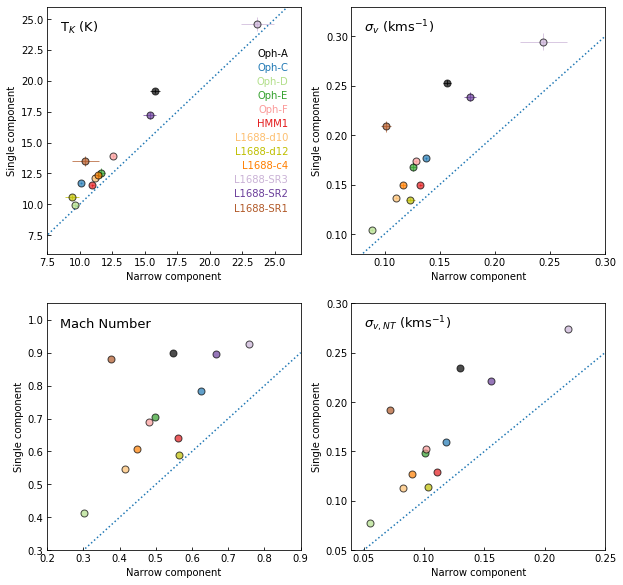

In [103]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(10,10))
i = 0
ylabel = 0.8



for reg in sort_reg:
    par_c_n, par_c_b, err_c_n, err_c_b = separate_comp(pars[reg],errs[reg])
    par_1b_n, par_1b_b, err_1b_n, err_1b_b = separate_comp(pars[reg+'_1b'], errs[reg+'_1b'])
    par_2b_n, par_2b_b, err_2b_n, err_2b_b = separate_comp(pars[reg+'_2b'], errs[reg+'_2b'])

    if par_2b_n[0] == 3 or par_2b_n[0]>50:
        par_2b_n[0] = np.nan
        err_2b_n[0] = np.nan    
    
    ax[0,0].errorbar([par_c_n[0]], [pars1[reg][0]] , xerr=[err_c_n[0]], yerr=[errs1[reg][0]], 
                   c=clr[reg], alpha=0.7, elinewidth=1, mec='k', ls='-', lw=1, marker='o', ms=7)

    ax[0,1].errorbar([par_c_n[3]], [pars1[reg][3]] , xerr=[err_c_n[3]], yerr=[errs1[reg][3]], 
                 c=clr[reg], alpha=0.7, elinewidth=1, mec='k', ls='-', lw=1, marker='o', ms=7)
    
    ax[1,0].errorbar([mach(par_c_n[0],par_c_n[3])],[mach(pars1[reg][0],pars1[reg][3])] , 
                   c=clr[reg], alpha=0.7, elinewidth=1, mec='k', ls='-', lw=1, marker='o', ms=7)
    
    ax[1,1].errorbar([mach(par_c_n[0], par_c_n[3], return_sig_nt=True)], [mach(pars1[reg][0], pars1[reg][3], 
                                                                             return_sig_nt=True)] , 
                   c=clr[reg], alpha=0.7, elinewidth=1, mec='k', ls='-', lw=1, marker='o', ms=7)

    
    ax[0,0].text( 0.95, ylabel, reg_lab[reg], color=clr[reg], transform=ax[0,0].transAxes, fontsize=10, 
                 horizontalalignment='right')
    
    ylabel -= 0.057
    
plt.setp( ax, xlabel = 'Narrow component' )
plt.setp( ax, ylabel = 'Single component' )

ax[0,0].set_xlim(7.5,27)
ax[0,0].set_ylim(6,26)

ax[0,1].set_xlim(0.07,0.3)
ax[0,1].set_ylim(0.08,0.33)

ax[1,0].set_xlim(0.2,0.9)
ax[1,0].set_ylim(0.3,1.05)

ax[1,1].set_xlim(0.04,0.25)
ax[1,1].set_ylim(0.05,0.3)

ax[0,0].plot([0,26],[0,26],':')
ax[0,1].plot([0,0.3],[0,0.3],':')
ax[1,0].plot([0,0.9],[0,0.9],':')
ax[1,1].plot([0,0.25],[0,0.25],':')      
        
ax[0,0].text(0.05, 0.9, 'T$_K$ (K)', color='k', transform=ax[0,0].transAxes, fontsize=13)
ax[0,1].text(0.05, 0.9, '$\sigma_v$ (kms$^{-1}$)', color='k', transform=ax[0,1].transAxes, fontsize=13)
ax[1,0].text(0.05, 0.9, 'Mach Number', color='k', transform=ax[1,0].transAxes, fontsize=13)
ax[1,1].text(0.05, 0.9, '${\sigma_{v,NT}}$ (kms$^{-1}$)', color='k', transform=ax[1,1].transAxes, fontsize=13)
fig.savefig("para_n_cmp_vs_1_cmp.pdf")